## Data, Losses, Metrics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from dipeptides.data import SpiceData
root = "../fit-dipeptides/data/spice-dipep-dipolar.h5"
cutoff = 4.0
edata = SpiceData(root,cutoff,batch_size=1,in_memory=False,valid_p=0.1,test_p=0)
for batch in edata.val_dataloader():
    exdatabatch = batch
    break
exdatabatch

Batch(atomic_numbers=[45], batch=[45], cell=[3, 3], dipole=[1, 3], edge_index=[2, 718], energy=[1], force=[45, 3], mbi_charges=[45], positions=[45, 3], ptr=[2], quadrupole=[1, 3, 3], shifts=[718, 3], unit_shifts=[718, 3])

## Load Models

In [3]:
#Losses
import torch
from cace.tasks import GetLoss
e_loss = GetLoss(
    target_name="energy",
    predict_name='pred_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1,
)
f_loss = GetLoss(
    target_name="force",
    predict_name='pred_force',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000,
)
losses = [e_loss,f_loss]

#Metrics
from cace.tools import Metrics
e_metric = Metrics(
            target_name="energy",
            predict_name='pred_energy',
            name='e',
            metric_keys=["rmse"],
            per_atom=True,
        )
f_metric = Metrics(
            target_name="force",
            predict_name='pred_force',
            metric_keys=["rmse"],
            name='f',
        )
metrics = [e_metric,f_metric]

In [4]:
from cace.tasks import LightningData, LightningTrainingTask
from dipeptides.model import make_cace_lr
import glob

# LR model
lr_model = make_cace_lr(cutoff=cutoff,lr="SOG")
# lr_model.models[1].output_modules[1].shift_1 = torch.nn.Parameter(lr_model.models[1].output_modules[1].shift_1, requires_grad=True)
# lr_model.models[1].output_modules[1].amplitude_1 = torch.nn.Parameter(lr_model.models[1].output_modules[1].amplitude_1, requires_grad=True)
# lr_model.models[1].output_modules[1].register_parameter("shift_1", lr_model.models[1].output_modules[1].shift_1)
# lr_model.models[1].output_modules[1].register_parameter("amplitude_1", lr_model.models[1].output_modules[1].amplitude_1)
# lr_model.models[1].output_modules[1].ene_factor = torch.nn.Parameter(torch.zeros(1),requires_grad=True)
# lr_model.models[1].output_modules[1].register_parameter("ene_factor", lr_model.models[1].output_modules[1].ene_factor)
lr_model.cuda()
lr_model(exdatabatch.cuda())
lr_task = LightningTrainingTask(lr_model,losses=losses,metrics=metrics,
                             logs_directory="model_runs/lightning_logs",name="lol",
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': 0.01},
                            )
chkpt = glob.glob(f"../fit-dipeptides/lightning_logs/cutoff_4.020250501_162620_cace_dipep_c4_dipolar/version_0/checkpoints/epoch=499-step=61500.ckpt")[0]
lr_task.load(chkpt)
lr_task.model.cuda()

#SR model
sr_model = make_cace_lr(cutoff=cutoff,lr="CACE")
# sr_model = make_cace_lr(cutoff=cutoff,lr=False)
sr_model.cuda()
sr_model(exdatabatch.cuda())
sr_task = LightningTrainingTask(sr_model,losses=losses,metrics=metrics,
                             logs_directory="model_runs/lightning_logs",name="lol",
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': 0.01},
                            )
chkpt = glob.glob(f"../fit-dipeptides/data/models/sr-model0.ckpt")[0]
sr_task.load(chkpt)
sr_task.model.cuda()

Loading model from /dssg/home/acct-matxzl/matxzl/Yajie/MDNN/cace-lr-fit-main/fit-dipeptides/lightning_logs/cutoff_4.020250501_162620_cace_dipep_c4_dipolar/version_0/checkpoints/epoch=499-step=61500.ckpt ...
Loading successful!
Loading model from /dssg/home/acct-matxzl/matxzl/Yajie/MDNN/cace-lr-fit-main/fit-dipeptides/data/models/sr-model0.ckpt ...
Loading successful!


LightningModel(
  (model): NeuralNetworkPotential(
    (postprocessors): ModuleList()
    (representation): Cace(
      (node_onehot): NodeEncoder(num_classes=4)
      (node_embedding_sender): NodeEmbedding(num_classes=4, embedding_dim=4)
      (node_embedding_receiver): NodeEmbedding(num_classes=4, embedding_dim=4)
      (edge_coding): EdgeEncoder(directed=True)
      (radial_basis): BesselRBF(cutoff=4.0, n_rbf=6, trainable=True)
      (cutoff_fn): PolynomialCutoff(p=6.0, cutoff=4.0)
      (angular_basis): AngularComponent(l_max=4)
      (radial_transform): SharedRadialLinearTransform(
        (weights): ParameterList(
            (0): Parameter containing: [torch.float32 of size 6x12x16 (cuda:0)]
            (1): Parameter containing: [torch.float32 of size 6x12x16 (cuda:0)]
            (2): Parameter containing: [torch.float32 of size 6x12x16 (cuda:0)]
            (3): Parameter containing: [torch.float32 of size 6x12x16 (cuda:0)]
            (4): Parameter containing: [torch.float3

In [5]:
lr_model.models[1].output_modules[1].ene_factor

Parameter containing:
tensor(0., device='cuda:0', requires_grad=True)

In [6]:
lr_model.models[1].output_modules[1].shift_1

Parameter containing:
tensor([2.9071e+00, 6.5260e+00, 1.3809e+01, 2.5653e+01, 4.2870e+01, 8.6042e+01,
        1.7788e+02, 3.6230e+02, 7.2771e+02, 1.4560e+03, 2.9120e+03, 5.8239e+03],
       device='cuda:0', requires_grad=True)

## Charges / Dipoles / Quads

In [7]:
import numpy as np
from cace.tools import scatter_sum
import matplotlib.pyplot as plt
fac = (90.0474)**0.5*1.15
# fac = 1

atomic_nums = []
nn_charges = []
mbi_charges = []
nn_dipoles = []
mbi_dipoles = []
dft_dipoles = []
nn_quads = []
mbi_quads = []
dft_quads = []

# nn_force = []
nn_energy = []
for batch in edata.val_dataloader():
    batch.cuda()
    atomic_nums.append(batch["atomic_numbers"].squeeze().cpu().detach().numpy())

    ####### NN charges #######
    out = lr_task.model(batch)
    nn_q = out["q"]/fac
    mbi_q = batch["mbi_charges"]
    nn_charges.append(nn_q.squeeze().cpu().detach().numpy())
    mbi_charges.append(mbi_q.squeeze().cpu().detach().numpy())

    ####### force&energy ######
    # nn_f = out["pred_force"]
    nn_e = out["pred_energy"]
    nn_energy.append(nn_e.squeeze().cpu().detach().numpy())

    ####### Dipoles #######
    nn_dipole = (batch["positions"] * nn_q).sum(dim=0)
    mbi_dipole = (batch["positions"] * mbi_q[:,None]).sum(dim=0)
    dft_dipole = batch["dipole"].squeeze()
    nn_dipoles.append(nn_dipole.squeeze().cpu().detach().numpy())
    mbi_dipoles.append(mbi_dipole.squeeze().cpu().detach().numpy())
    dft_dipoles.append(dft_dipole.squeeze().cpu().detach().numpy())    

    ####### Quads ########
    rij = batch["positions"][:,:,None] * batch["positions"][:,None,:]
    nn_quad = (nn_q.reshape(-1,1,1) * rij).sum(dim=0)
    mbi_quad = (mbi_q.reshape(-1,1,1) * rij).sum(dim=0)
    dft_quad = batch["quadrupole"].squeeze()

    #Subtract trace to compare
    #This is necessary as the positions from SPICE were centered to the origin
    eye = torch.eye(3).to(batch["energy"].device)
    nn_quad = nn_quad - 1/3*nn_quad.trace()*eye
    mbi_quad = mbi_quad - 1/3*mbi_quad.trace()*eye
    dft_quad = dft_quad - 1/3*dft_quad.trace()*eye

    #Add
    nn_quads.append(nn_quad.squeeze().cpu().detach().numpy())
    mbi_quads.append(mbi_quad.squeeze().cpu().detach().numpy())
    dft_quads.append(dft_quad.squeeze().cpu().detach().numpy())

atomic_nums = np.hstack(atomic_nums)
nn_charges = np.hstack(nn_charges)
mbi_charges = np.hstack(mbi_charges)
nn_dipoles = np.hstack(nn_dipoles)
mbi_dipoles = np.hstack(mbi_dipoles)
dft_dipoles = np.hstack(dft_dipoles)
nn_quads = np.hstack(nn_quads)
mbi_quads = np.hstack(mbi_quads)
dft_quads = np.hstack(dft_quads)

In [8]:
#R2 scores
import scipy
print("MBI vs. NN charges:",np.round(scipy.stats.pearsonr(nn_charges.ravel(),mbi_charges.ravel())[0],2))
print("#######################")
print("MBI vs. NN dipoles:",np.round(scipy.stats.pearsonr(nn_dipoles.ravel(),mbi_dipoles.ravel())[0],2))
print("DFT vs. NN dipoles:",np.round(scipy.stats.pearsonr(nn_dipoles.ravel(),dft_dipoles.ravel())[0],2))
print("DFT vs. MBI dipoles:",np.round(scipy.stats.pearsonr(mbi_dipoles.ravel(),dft_dipoles.ravel())[0],3))
print("#######################")
print("MBI vs. NN quads:",np.round(scipy.stats.pearsonr(mbi_quads.ravel(),nn_quads.ravel())[0],2))
print("DFT vs. NN quads:",np.round(scipy.stats.pearsonr(dft_quads.ravel(),nn_quads.ravel())[0],2))
print("DFT vs. MBI quads:",np.round(scipy.stats.pearsonr(dft_quads.ravel(),mbi_quads.ravel())[0],2))

MBI vs. NN charges: 0.92
#######################
MBI vs. NN dipoles: 0.99
DFT vs. NN dipoles: 0.99
DFT vs. MBI dipoles: 0.998
#######################
MBI vs. NN quads: 0.99
DFT vs. NN quads: 0.95
DFT vs. MBI quads: 0.96


In [9]:
#MAE
from sklearn.metrics import mean_absolute_error
print("MBI vs. NN charges:",np.round(mean_absolute_error(nn_charges.ravel(),mbi_charges.ravel()),3))
print("#######################")
print("MBI vs. NN dipoles:",np.round(mean_absolute_error(nn_dipoles.ravel(),mbi_dipoles.ravel()),3))
print("DFT vs. NN dipoles:",np.round(mean_absolute_error(nn_dipoles.ravel(),dft_dipoles.ravel()),3))
print("DFT vs. MBI dipoles:",np.round(mean_absolute_error(mbi_dipoles.ravel(),dft_dipoles.ravel()),3))
print("#######################")
print("MBI vs. NN quads:",np.round(mean_absolute_error(mbi_quads.ravel(),nn_quads.ravel()),3))
print("DFT vs. NN quads:",np.round(mean_absolute_error(dft_quads.ravel(),nn_quads.ravel()),3))
print("DFT vs. MBI quads:",np.round(mean_absolute_error(dft_quads.ravel(),mbi_quads.ravel()),3))

MBI vs. NN charges: 0.227
#######################
MBI vs. NN dipoles: 0.151
DFT vs. NN dipoles: 0.132
DFT vs. MBI dipoles: 0.063
#######################
MBI vs. NN quads: 0.434
DFT vs. NN quads: 0.779
DFT vs. MBI quads: 0.725


## Charges

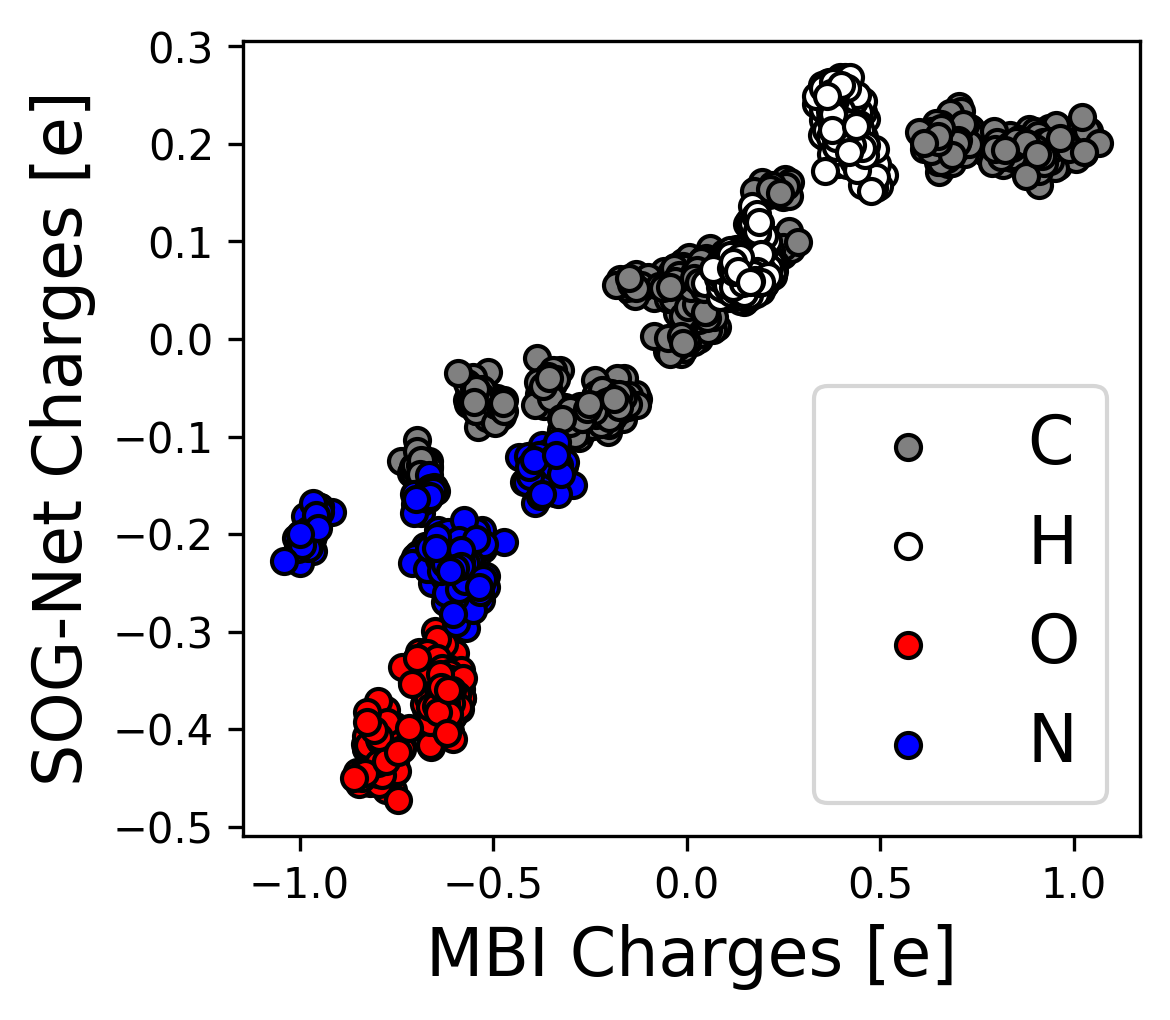

In [19]:
fs=16
djvfont = {'fontname':'DejaVu Sans'}
eltrans = {1:"H",6:"C",7:"N",8:"O"}
colors = {1:"white",6:"grey",7:"blue",8:"red"}
plt.subplots(figsize=(4,3.5),dpi=300)
for el in [6,1,8,7]:
    idx = np.where(atomic_nums == el)[0]
    mbi = mbi_charges[idx]
    nnc = nn_charges[idx]
    plt.scatter(mbi,nnc,label=eltrans[el],color=colors[el],edgecolors='black')
plt.xlabel("MBI Charges [e]",fontsize=fs,**djvfont)
plt.ylabel("SOG-Net Charges [e]",fontsize=fs,**djvfont)
plt.legend(loc="lower right",prop={'family':'DejaVu Sans', 'size':fs})
plt.tight_layout()
plt.savefig("figures/sog_vs_mbi.png",dpi=500)

## Dipole Moments

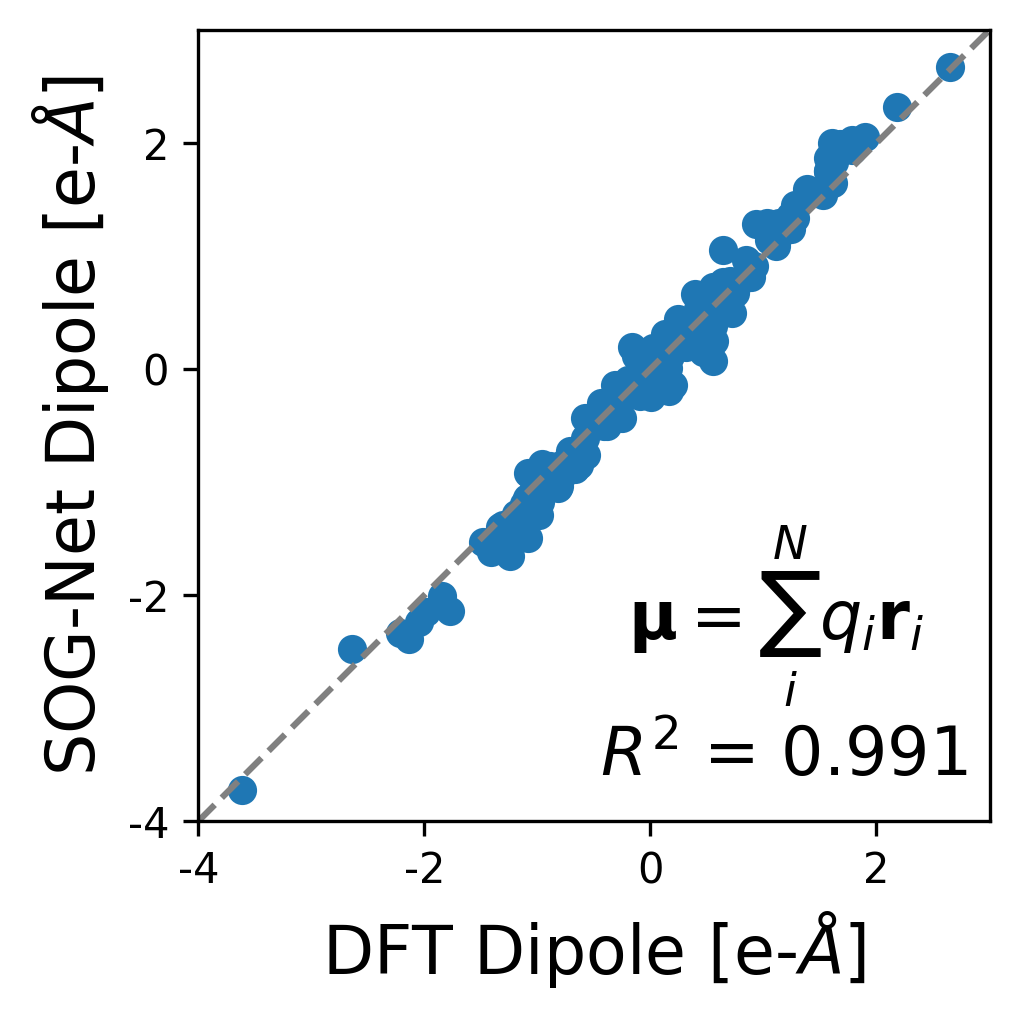

In [16]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5),dpi=300)
r2 = np.round(scipy.stats.pearsonr(dft_dipoles.ravel(),nn_dipoles.ravel())[0],3)
plt.scatter(dft_dipoles.ravel(),(nn_dipoles).ravel())
fs=16
plt.xlabel("DFT Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.ylabel("SOG-Net Dipole [e-$\AA$]",fontsize=fs,**djvfont)
xmin, xmax = -4,3
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 2
plt.xticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.yticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.text(-0.2,-2.4,"$\mathbf{\mu} = \sum_i^N q_i \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.45,-3.6,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/dipoles_dft_les.png",dpi=500)

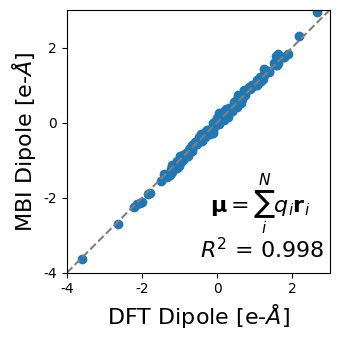

In [12]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5))
r2 = np.round(scipy.stats.pearsonr(dft_dipoles.ravel(),mbi_dipoles.ravel())[0],3)
plt.scatter(dft_dipoles.ravel(),mbi_dipoles.ravel())
fs=16
plt.xlabel("DFT Dipole [e-$\AA$]",fontsize=fs,**djvfont)
plt.ylabel("MBI Dipole [e-$\AA$]",fontsize=fs,**djvfont)
xmin, xmax = -4,3
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 2
plt.xticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.yticks(np.arange(xmin,xmax,s),np.arange(xmin,xmax,s))
plt.text(-0.2,-2.4,"$\mathbf{\mu} = \sum_i^N q_i \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.45,-3.6,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/dipoles_dft_mbi.png",dpi=500)

## Quads

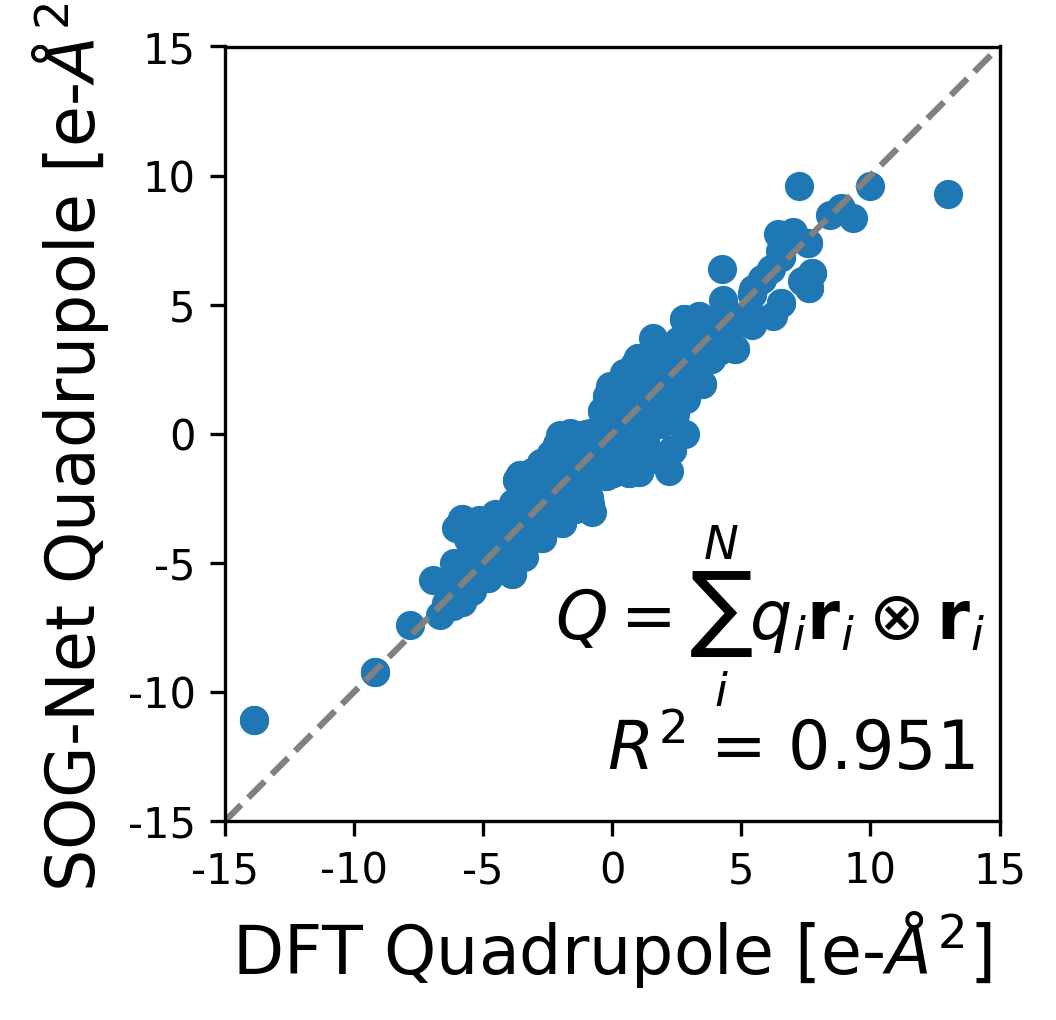

In [13]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5),dpi=300)
r2 = np.round(scipy.stats.pearsonr(dft_quads.ravel(),nn_quads.ravel())[0],3)
plt.scatter(dft_quads.ravel(),nn_quads.ravel())
fs=16
plt.xlabel("DFT Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.ylabel("SOG-Net Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
xmin, xmax = -15,15
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 5
plt.xticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.yticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.text(-2.2,-8,"$Q = \sum_i^N q_i \mathbf{r}_{i} \otimes \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.2,-13,f"$R^2$ = {r2}",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/quads_dft_les.png",dpi=500)

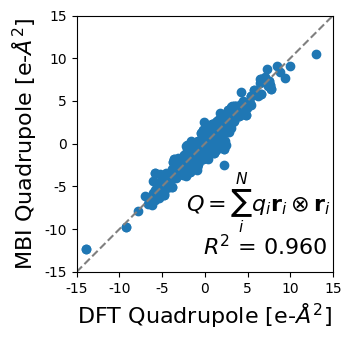

In [14]:
djvfont = {'fontname':'DejaVu Sans'}
plt.subplots(figsize=(4,3.5))
r2 = np.round(scipy.stats.pearsonr(dft_quads.ravel(),mbi_quads.ravel())[0],3)
plt.scatter(dft_quads.ravel(),mbi_quads.ravel())
fs=16
plt.xlabel("DFT Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
plt.ylabel("MBI Quadrupole [e-$\AA^2$]",fontsize=fs,**djvfont)
xmin, xmax = -15,15
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
s = 5
plt.xticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.yticks(np.arange(xmin,xmax+1,s),np.arange(xmin,xmax+1,s))
plt.text(-2.2,-8,"$Q = \sum_i^N q_i \mathbf{r}_{i} \otimes \mathbf{r}_{i}$",fontsize=fs,**djvfont)
plt.text(-0.2,-13,f"$R^2$ = {r2}0",fontsize=fs,**djvfont)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig("figures/quads_dft_mbi.png",dpi=500)

## Performance on Test Set

In [15]:
from dipeptides.data import SpiceData
import pandas as pd
root = "data/spice-dipep-dipolar-test.h5"
cutoff = 4.0
edata_test = SpiceData(root,cutoff,batch_size=4,in_memory=True,valid_p=0,test_p=1)
df = pd.DataFrame()

batch_all = {}
sr_all = {}
lr_all = {}
for batch in edata_test.test_dataloader():
    batch.cuda()
    lr_out = lr_task.model(batch)
    sr_out = sr_task.model(batch)
    for k in ["pred_energy","pred_force"]:
        if k not in sr_all:
            sr_all[k] = []
        if k not in lr_all:
            lr_all[k] = []
        lr_all[k].append(lr_out[k])
        sr_all[k].append(sr_out[k])
    for k in ["energy","force"]:
        if k not in batch_all:
            batch_all[k] = []
        batch_all[k].append(batch[k])

for k in ["pred_energy"]:
    lr_all[k] = torch.hstack(lr_all[k])
    sr_all[k] = torch.hstack(sr_all[k])
for k in ["pred_force"]:
    lr_all[k] = torch.vstack(lr_all[k])
    sr_all[k] = torch.vstack(sr_all[k])
for k in ["energy"]:
    batch_all[k] = torch.hstack(batch_all[k])
for k in ["force"]:
    batch_all[k] = torch.vstack(batch_all[k])

edata_test = SpiceData(root,cutoff,batch_size=1000,in_memory=True,valid_p=0,test_p=1)
for batch in edata_test.test_dataloader():
    batch_all["batch"] = batch["batch"].cuda()
    break

import pandas as pd
df = pd.DataFrame()
df.loc["E","CACE-SOG test"] = e_metric(lr_all,batch_all)["rmse"].item()
df.loc["F","CACE-SOG test"] = f_metric(lr_all,batch_all)["rmse"].item()
df.loc["E","CACE-SR test"] = e_metric(sr_all,batch_all)["rmse"].item()
df.loc["F","CACE-SR test"] = f_metric(sr_all,batch_all)["rmse"].item()
df

,CACE-SOG test,CACE-SR test
E,0.001281,0.002354
F,0.061158,0.072430
